In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

## Load data

In [2]:
# Copy results of NF here
#%cp /Users/katianakontolati/PycharmProjects/pytorch-flows/results/results.npz data/

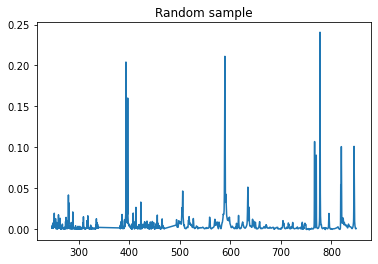

(426, 5606)

In [3]:
# Get calibration samples and labels 

# Load observations
file = np.load('data/NF_mixed_train_test_data.npz')  
calib_data = file['y_calib'] # get earth data after earth_2_mars transform

# Load wavelengths
w = file['w']
plt.plot(w, calib_data[0,:])
plt.title('Random sample')
plt.show()
calib_data.shape

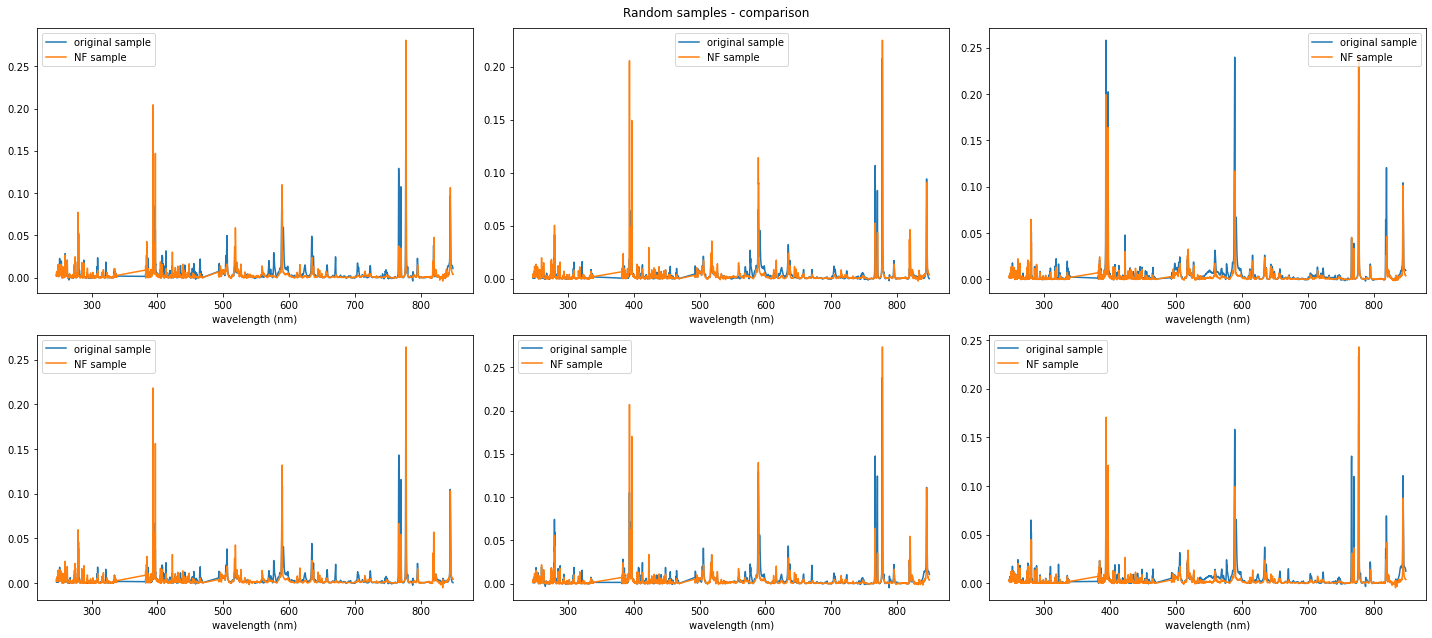

In [4]:
# Load results from NF training
file1 = np.load('data/results.npz') 
calib_data_gaussian = file1['z'] # load calibration data to gaussian (X --> Z)

# Load noise and corresponding LIBS spectra (Z --> X)
noise = file1['noise']
libs_from_noise = file1['forward_flow']

# Plot samples in two random dimensions
#plt.scatter(calib_data_gaussian[:,1], calib_data_gaussian[:,2]) # notice a few outliers
#plt.show()

# Compare an original LIBS sample with one generated with the NF model
# Plot before normalization
fig = plt.figure(figsize=(20, 9), facecolor='white')

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    rr = np.random.randint(0,400)
    plt.plot(w, calib_data[rr,:], label='original sample')
    plt.plot(w, libs_from_noise[rr,:], label='NF sample')
    #plt.ylim(0,0.25)
    plt.legend()
    plt.xlabel('wavelength (nm)')
plt.suptitle('Random samples - comparison')
fig.tight_layout()
plt.show()

In [5]:
# Load compositions
file2 = np.load('data/calibration_data.npz')
comp = file2['c']
comp.shape

(426, 8)

## Train linear regressor models for each oxide

### PLS regression

In [6]:
from sklearn.cross_decomposition import PLSRegression

# train 8 PLS models, one for each oxide
split, max_comp = 400, 50
models_best, scores_best = [0]*comp.shape[1], [0]*comp.shape[1]
for j in range(comp.shape[1]):
    curr_best = 0
    for i in range(max_comp):
        n_comp = i+1
        pls = PLSRegression(n_components=n_comp, max_iter=3000, tol=1e-4)
        pls.fit(calib_data[:split], comp[:split,j])
        score = pls.score(calib_data[split:], comp[split:,j]) # test on remaining samples
        if score > curr_best:
            curr_best = score
            models_best[j] = pls
            scores_best[j] = curr_best

In [7]:
for i in range(comp.shape[1]):
    print('# of comp. for model {}: {}'.format(i+1, models_best[i].get_params()['n_components']))

# of comp. for model 1: 4
# of comp. for model 2: 17
# of comp. for model 3: 19
# of comp. for model 4: 4
# of comp. for model 5: 15
# of comp. for model 6: 11
# of comp. for model 7: 9
# of comp. for model 8: 40


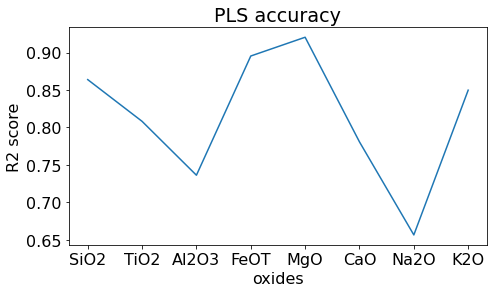

In [8]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']
plt.figure(figsize=(7.5,4))
plt.rcParams.update({'font.size': 16})
plt.plot(oxides, scores_best)
plt.ylabel('R2 score')
plt.xlabel('oxides')
plt.title('PLS accuracy')
plt.show()

## Uncertainty quantification (UQ)

### Choose nearest neighbors and compute uncertainty of predictions

In [9]:
print(noise.shape, libs_from_noise.shape)

(10000, 5606) (10000, 5606)


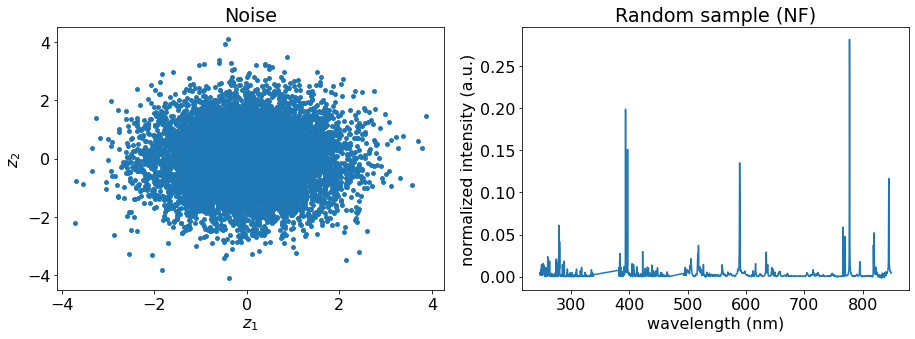

In [10]:
fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(noise[:,0], noise[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Noise')
plt.subplot(1,2,2)
plt.plot(w, libs_from_noise[0,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.title('Random sample (NF)')
fig.tight_layout()
plt.show()

In [11]:
# Choose one point and find its k-nearest neighbors
n_neighbors = 50
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2)
knn.fit(noise)

rand_sample = np.random.randint(0,noise.shape[0])
nn = knn.kneighbors(X=noise[rand_sample,:].reshape(1, -1), n_neighbors=n_neighbors, return_distance=False) # indices

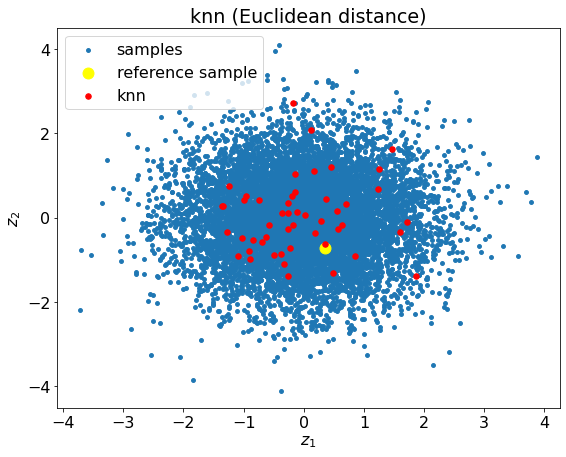

In [12]:
fig = plt.figure(figsize=(9,7))
plt.scatter(noise[:,0], noise[:,1], s=15, label='samples')
plt.scatter(noise[0,0], noise[0,1], s=120, c='yellow', label='reference sample')
plt.scatter(noise[nn,0], noise[nn,1], s=30, c='r', label='knn')
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('knn (Euclidean distance)')
plt.legend()
plt.show()

In [13]:
# Predict compositions for samples and its neighbors with the pretrained PLS models
pred = [] # list 
for i in range(comp.shape[1]):
    pred.append(models_best[i].predict(libs_from_noise[nn].reshape(nn.shape[1], libs_from_noise.shape[1])))

In [14]:
pred_ar = np.array((pred)).reshape(comp.shape[1], nn.shape[1]) # convert list to numpy array
pred_ar.shape

(8, 50)

In [15]:
# Compute mean and max-min
mean = np.mean(pred_ar, axis=1)
p_max = np.amax(pred_ar, axis=1)
p_min = np.amin(pred_ar, axis=1)

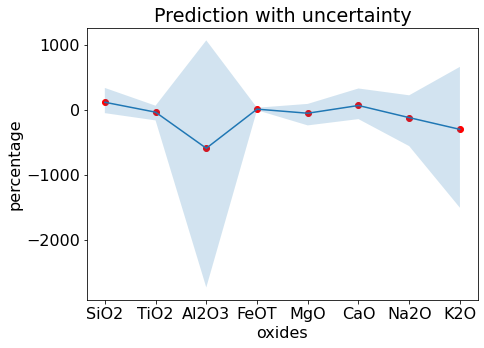

In [27]:
# Plot distributions of predictions
plt.figure(figsize=(7,5))
plt.plot(oxides, mean)
plt.scatter(oxides, mean, c='r')
plt.fill_between(oxides, p_min, p_max, alpha=0.2)
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.title('Prediction with uncertainty')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.show()